<a href="https://colab.research.google.com/github/CDU-data-science-team/zero-shot/blob/feature-Huggingface_transformer/Patient_Feedback_with_Hugging_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 7.3 MB/s 
     |████████████████████████████████| 3.3 MB 48.0 MB/s 
     |████████████████████████████████| 636 kB 55.9 MB/s 
     |████████████████████████████████| 895 kB 57.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


#Load important libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from transformers import pipeline

from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, plot_confusion_matrix

from time import time
import datetime
from warnings import filterwarnings
filterwarnings("once", category=DeprecationWarning) # Display just the first matching deprecation warnings (e.g. warning that multi_class is changing to multi_label)

# Needed Functions

In [3]:
def time_convert(seconds):
  """
  Function to convert seconds to hour, minute and second
  :param int seconds: number of seconds
  :return: result (`string`): The derived hour(s), minute(s), and seconds.
  """
  min, sec = divmod(seconds, 60)
  hour, min = divmod(min, 60)
  result = "%d:%02d:%02d" % (hour, min, sec)
  return result

def class_accuracy (cat, y_true, y_pred):
  """
  Function for individual Class Accuracy score
  :param string cat: name of class.
  :param array y_true: True classes, shape = [n_samples].
  :param array y_pred: Predicted classes, shape = [n_samples].
  :return: cba (`float`): The individual Class Accuracy score (returned as percentage)
  """
  total = list(y_true).count(cat)
  y_true_ = list(y_true)
  y_pred_ = list(y_pred)
  correct = [i for i, x in enumerate(y_true_) if x == str(cat) and y_true_[i] == y_pred_[i]]
  acc = len(correct)/total 
  return round((acc*100),2)
  
def plot_conf_mat (y_true, y_pred, cmap="YlGnBu", ax=None, cm_perc=True):
    """
    Function for ploting confusion matrix
    :param array y_true: True classes, shape = [n_samples].
    :param array y_pred: Predicted classes, shape = [n_samples]. 
    :param string cmap: color palette.
    :param  Axes object ax: subplot axis.
    :param bool cm_perc: if true the percentage accuracy is plot.
    :return: (`matplotlib plot object`): the confusion matrix plot
    """
    mat = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    mat_sum = np.sum(mat, axis=1, keepdims=True)      #sum across rows (actual label) and retain the matrix dimesion in the return array
    mat_perc = mat / mat_sum.astype(float) * 100
    
    if cm_perc:
        mat_df = pd.DataFrame(mat_perc, index=np.unique(y_true), columns=np.unique(y_true))
    else:
        mat_df = pd.DataFrame(mat, index=np.unique(y_true), columns=np.unique(y_true))
    mat_df.index.name = 'Actual'
    mat_df.columns.name = 'Predicted'
    
    sns.heatmap(mat_df,
                cmap= cmap,                             # color palette
                annot=True,                             # to display the values 
                fmt='.1f',                              # round up the values
                linewidths=.5,                          # Add lines between the cells
                annot_kws={"size": 10},                 # font size
                ax=ax,
                cbar_kws={"shrink": .70,                # adjust the size of the sidebar 
                      #    "orientation": "horizontal"  # change the sidebar position
                }, 
    )

#Load Data

In [4]:
filepath = 'new_data.csv' 
df = pd.read_csv(filepath, usecols=['label', 'feedback'])
#df = pd.read_csv(filepath, usecols=['label', 'feedback'], nrows=1000) #take a small sample to test diffrent nli models for zeroshot

# Prepare data for prediction

In [5]:
# Fill missing values with 'Nothing'
df.fillna('Nothing', inplace=True)
print(df.shape)
df.head()

(9291, 2)


,label,feedback
0,Couldn't be improved,Nothing.
1,Environment/ facilities,Temperature in theatre a little low.
2,Access,Same service available at Bingham Health Centre.
3,Communication,Appointment details given over phone - no phys...
4,Communication,On one occasion I was not made aware that my a...


In [6]:
sequence = df.feedback.values
candidate_labels = df.label.unique()
print(len(candidate_labels))
candidate_labels


9


array(["Couldn't be improved", 'Environment/ facilities', 'Access',
       'Communication', 'Dignity', 'Staff', 'Care received',
       'Transition/coordination', 'Miscellaneous'], dtype=object)

#Prediction

In [18]:
#List of pretrained Zeroshot models to test
#uncheck the model list to run

# List of models with predictions above random chance (best performing models)
models = ['valhalla/distilbart-mnli-12-9', 'valhalla/distilbart-mnli-12-1',
       'valhalla/distilbart-mnli-12-6', 'facebook/bart-large-mnli',
       'cross-encoder/nli-deberta-base']

# #list of all explored models 
# models = ['roberta-large-mnli', 'facebook/bart-large-mnli', 'typeform/distilbert-base-uncased-mnli',
#           'cross-encoder/nli-MiniLM2-L6-H768', 'cross-encoder/nli-distilroberta-base',
#           'cross-encoder/nli-roberta-base', 'cross-encoder/nli-deberta-base', 
#           'valhalla/distilbart-mnli-12-1', 'valhalla/distilbart-mnli-12-9', 'valhalla/distilbart-mnli-12-6',
#           'Recognai/bert-base-spanish-wwm-cased-xnli',
#          # 'typeform/roberta-large-mnli'           #takes long  time to predict
#           ]

#for testing the pipeline
#models = ['cross-encoder/nli-deberta-base']   

In [19]:
%%time
#model_name = []
model_score = []
model_balanced_score = []
model_initialising_time = []
model_prediction_time = []
model_average_feedback_score = []
model_total_time = []
class_dict = {'model_name': []}
preds = []

# Loop through the list of models to try
for model in models:
  feedback_predict = []; feedback_predict_score = []  #list to hold the predicted class and its score

  # time the model initialization period
  start = time()
  # instantiate a zeroshot classifier object
  classifier = pipeline("zero-shot-classification", model=model, device=0) # utilize GPU
  end = time()
  initialising_time =  round(end-start) #tracks model initialisation time
    
  # Actual prediction
  # track model prediction time
  # to do multiclass classification set <multi_class=True>
  start2 = time()
  for i in range(len(df)):
    result = classifier(sequence[i], candidate_labels) 
    feedback_predict.append(result['labels'][0])
    feedback_predict_score.append(result['scores'][0]) 
  end2 = time()
  prediction_time = round(end2-start2) #tracks model prediction time 
  total_time = prediction_time + initialising_time
  preds.append(feedback_predict)

  # Model evaluation
  y_true = df.label.values
  y_pred = feedback_predict
  balanced_score = balanced_accuracy_score(y_true, y_pred)
  acc_score = accuracy_score(y_true, y_pred)

  # append the class score to the class dictionary
  if model not in class_dict['model_name']:
    class_dict['model_name'].append(model)
    for i in range(len(candidate_labels)):
      # check if the class is already a key in the dictionary
      if candidate_labels[i] not in class_dict: 
        class_dict[candidate_labels[i]] = [class_accuracy(candidate_labels[i], y_true, y_pred)]
      else: 
        class_dict[candidate_labels[i]].append(class_accuracy(candidate_labels[i], y_true, y_pred))

  # Update model performance tracking lists
  #model_name.append(model)
  model_score.append(round(acc_score*100, 2))   
  model_balanced_score.append(round(balanced_score*100, 2))     
  model_initialising_time.append(time_convert(initialising_time))
  model_prediction_time.append(time_convert(prediction_time))
  model_total_time.append(time_convert(total_time))
  model_average_feedback_score.append(round(np.mean(feedback_predict_score)*100, 2)) 

CPU times: user 37min 50s, sys: 25 s, total: 38min 15s
Wall time: 39min 40s


In [20]:
# create the model performance table and populate it for model comparism
Model_performance_df = pd.DataFrame.from_dict(class_dict)
Model_performance_df['accuracy_score'] = model_score
Model_performance_df['balanced_score'] = model_balanced_score
Model_performance_df['average_feedback_score'] = model_average_feedback_score
Model_performance_df['initialisation_time'] = model_initialising_time
Model_performance_df['prediction_time'] = model_prediction_time
Model_performance_df['total_time'] = model_total_time

# rearrange the column names to ensure model name come first
performance_df = Model_performance_df[['model_name', 'accuracy_score', 'balanced_score', 'average_feedback_score',
       'initialisation_time', 'prediction_time', 'total_time',
       'Couldn\'t be improved', 'Environment/ facilities', 'Access',
       'Communication', 'Dignity', 'Staff', 'Care received',
       'Transition/coordination', 'Miscellaneous']]
       
# Sort the table by values in model_score in ascending order and reset the index
performance_df.sort_values('accuracy_score', inplace=True, ascending=False)
performance_df = performance_df.reset_index(drop=True)

performance_df

,model_name,accuracy_score,balanced_score,average_feedback_score,initialisation_time,prediction_time,total_time,Couldn't be improved,Environment/ facilities,Access,Communication,Dignity,Staff,Care received,Transition/coordination,Miscellaneous
0,valhalla/distilbart-mnli-12-9,57.09,29.62,53.94,0:00:09,0:09:29,0:09:38,76.11,7.30,11.24,18.12,5.31,52.28,82.21,11.81,2.23
1,valhalla/distilbart-mnli-12-1,54.07,27.90,50.12,0:00:31,0:05:18,0:05:49,60.26,8.15,21.60,15.59,7.08,59.58,75.06,1.57,2.23
2,valhalla/distilbart-mnli-12-6,52.90,28.51,48.01,0:00:08,0:08:01,0:08:09,51.97,9.23,10.65,19.80,7.96,49.84,83.16,20.47,3.50
3,facebook/bart-large-mnli,52.51,27.63,53.86,0:00:54,0:11:01,0:11:55,83.54,8.58,8.58,12.08,3.54,29.30,84.94,16.54,1.59
4,cross-encoder/nli-deberta-base,51.39,30.43,47.52,0:00:21,0:03:47,0:04:08,52.64,28.76,10.95,35.25,1.77,46.70,73.74,9.45,14.65


# Visualize the data and Export it as csv

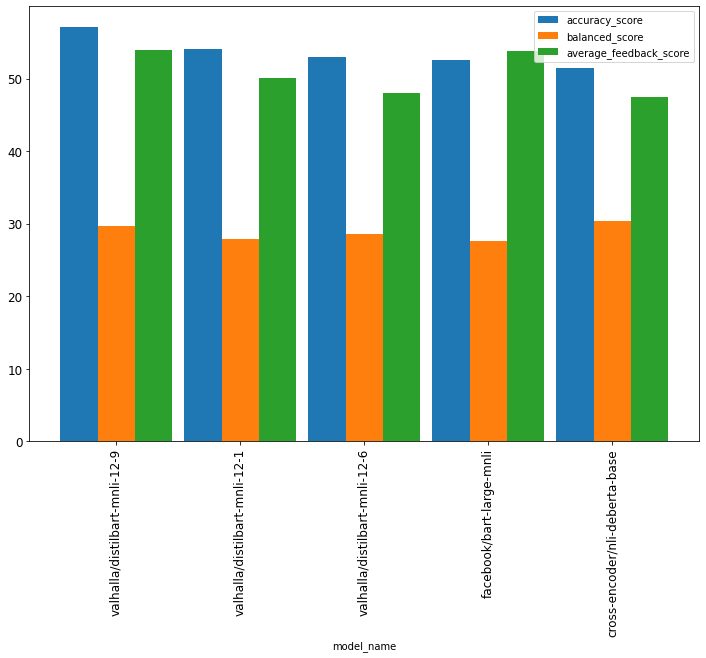

In [27]:
#set values in model name as index
model_df = performance_df.set_index(performance_df['model_name'])

model_df[['accuracy_score', 
          'balanced_score', 'average_feedback_score']]\
          .plot.bar(rot = 90, figsize=(12,8), fontsize=12, width=0.9)

# Export the model performance table
performance_df.to_csv('Models_performance.txt', index = False) 

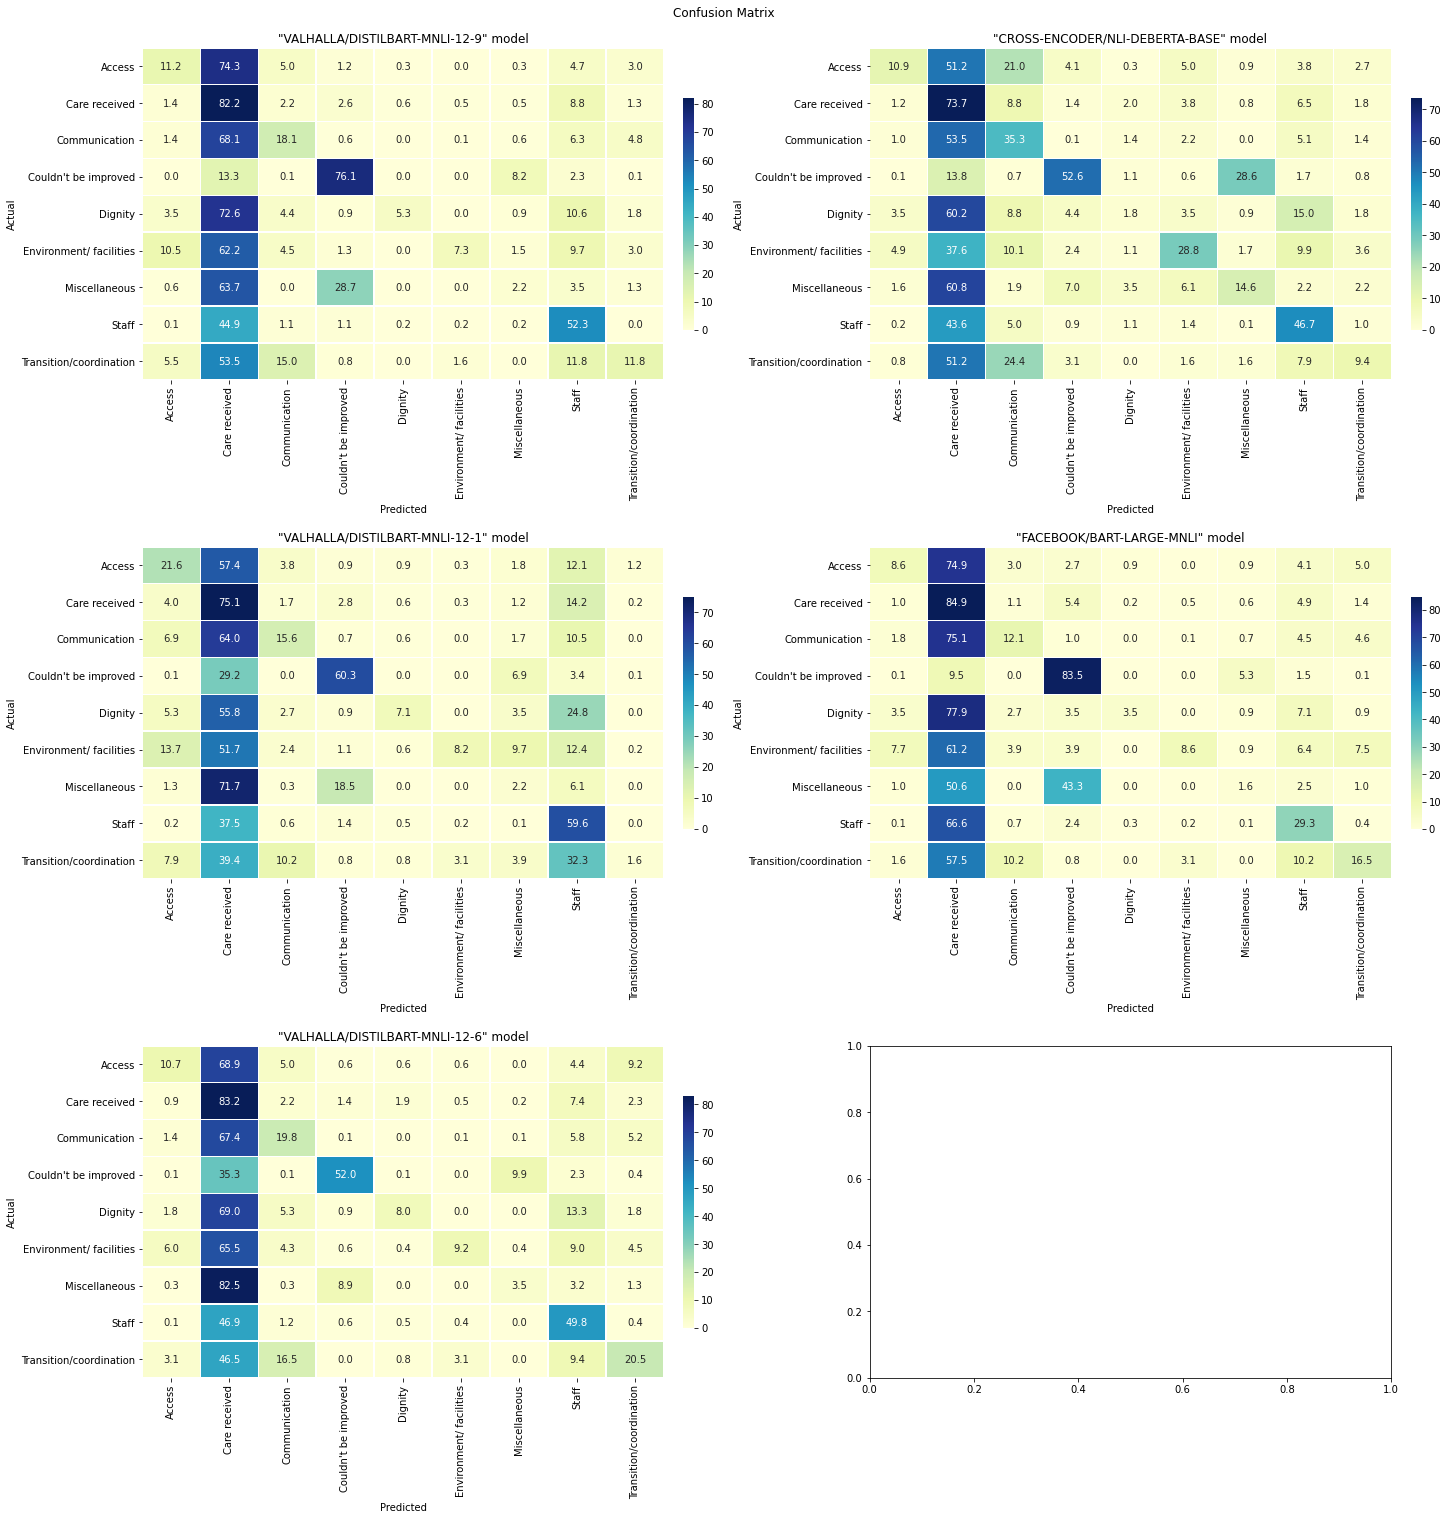

In [23]:
# visualise the confusion matrix for each model
row = len(models)//2+1
fig, axs = plt.subplots(row, 2,  
                        figsize=(10*2,7*row),     # create a 10x7 figure size for each plot 
                        constrained_layout=True)  # add space between each plot
fig.suptitle('Confusion Matrix')                  # add general title to the figures

for i, m in enumerate(models):
    y_pred = preds[i]
    if row == 1:
      ax = axs[i]                                 # handle visualisation when only one model is in the explored model list
    else:
      ax = axs[i,0] if i < row else axs[i%2,1]    # when 2 or more models are in the explored model list
    plot_conf_mat (y_true, y_pred, ax=ax)
    ax.set_title(f'\"{m.upper()}\" model')